In [3]:
import os
import torch
import numpy as np
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms (same as your original test transforms)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load test dataset
test_folder = "SelfCollectedTest"
if os.path.exists(test_folder):
    test_ds = datasets.ImageFolder(test_folder, transform=val_transforms)
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
    print(f"Loaded test set with {len(test_ds)} samples")
else:
    print(f"Error: {test_folder} not found")
    test_loader = None

Loaded test set with 808 samples


In [5]:
# Define SimpleCNN (same as in CustomCNN_BaseLine.ipynb)
class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        
        # Feature extraction layers
        self.features = torch.nn.Sequential(
            # First Conv Block
            torch.nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
            # Second Conv Block
            torch.nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Third Conv Block
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Fourth Conv Block
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Fifth Conv Block
            torch.nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(inplace=True),
            torch.nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Classifier
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)

In [6]:
# List of models to evaluate
model_configs = {
    "MobileNetV3-Small": {
        "model": models.mobilenet_v3_small(weights="IMAGENET1K_V1"),
        "path": "best_mnv3_small.pth"
    },
    "ResNet50": {
        "model": models.resnet50(weights="IMAGENET1K_V1"),
        "path": "best_resnet50.pth"
    },
    "EfficientNet-B0": {
        "model": models.efficientnet_b0(weights="IMAGENET1K_V1"),
        "path": "best_efficientnet_b0.pth"
    },
    "MobileNetV2": {
        "model": models.mobilenet_v2(weights="IMAGENET1K_V1"),
        "path": "best_mobilenet_v2.pth"
    },
    "CustomCNN": {
        "model": SimpleCNN(num_classes=2),
        "path": "best_custom_cnn.pth"
    }
}


In [7]:
# Modify models for 2 classes (diabetes, nondiabetes)
for model_name, config in model_configs.items():
    model = config["model"]
    if model_name.startswith("ResNet"):
        num_ftrs = model.fc.in_features
        model.fc = torch.nn.Linear(num_ftrs, 2)
    elif model_name.startswith("MobileNetV3"):
        num_ftrs = model.classifier[-1].in_features
        model.classifier[-1] = torch.nn.Linear(num_ftrs, 2)
    elif model_name.startswith("MobileNetV2"):
        num_ftrs = model.classifier[-1].in_features
        model.classifier[-1] = torch.nn.Linear(num_ftrs, 2)
    elif model_name.startswith("EfficientNet"):
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = torch.nn.Linear(num_ftrs, 2)
    elif model_name.startswith("VGG"):
        num_ftrs = model.classifier[-1].in_features
        model.classifier[-1] = torch.nn.Linear(num_ftrs, 2)
    elif model_name == "CustomCNN":
        # Already configured for 2 classes
        pass
    config["model"] = model.to(device)

In [8]:
# Function to evaluate performance metrics
def evaluate_performance(model, data_loader, device):
    model.eval()
    preds_all, labels_all, probs_all = [], [], []
    
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            preds_all.extend(preds)
            labels_all.extend(y.cpu().numpy())
            probs_all.extend(probs)
    
    # Calculate important metrics only
    accuracy = accuracy_score(labels_all, preds_all) * 100
    auc = roc_auc_score(labels_all, probs_all) if len(set(labels_all)) > 1 else 1.0
    precision, recall, f1, _ = precision_recall_fscore_support(labels_all, preds_all, average=None)
    cm = confusion_matrix(labels_all, preds_all)
    
    # Sensitivity and Specificity  
    sensitivity = recall[1] * 100  # Positive class (diabetes)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) * 100 if (cm[0, 0] + cm[0, 1]) > 0 else 0.0
    recall_diabetes = recall[1] * 100  # Recall for diabetes class
    
    return {
        "Accuracy (%)": accuracy,
        "AUC": auc,
        "Sensitivity (%)": sensitivity,
        "Specificity (%)": specificity,
        "Recall (%)": recall_diabetes
    }

In [9]:
# Evaluate performance metrics for each model
results = []
if test_loader is not None:
    for model_name, config in model_configs.items():
        model = config["model"]
        model_path = config["path"]
        
        # Load pretrained weights
        if os.path.exists(model_path):
            model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
        else:
            print(f"Warning: {model_path} not found, skipping {model_name}")
            continue
        
        metrics = evaluate_performance(model, test_loader, device)
        results.append({
            "Model": model_name,
            **metrics
        })

In [10]:
# Print results in a table format
print("\nModel Performance Comparison:")
print("-" * 85)
print(f"{'Model':<20} {'Accuracy (%)':<15} {'AUC':<10} {'Sensitivity (%)':<15} {'Specificity (%)':<15} {'Recall (%)':<12}")
print("-" * 85)
for result in results:
    print(f"{result['Model']:<20} {result['Accuracy (%)']:<15.2f} {result['AUC']:<10.3f} {result['Sensitivity (%)']:<15.2f} {result['Specificity (%)']:<15.2f} {result['Recall (%)']:<12.2f}")
print("-" * 85)


Model Performance Comparison:
-------------------------------------------------------------------------------------
Model                Accuracy (%)    AUC        Sensitivity (%) Specificity (%) Recall (%)  
-------------------------------------------------------------------------------------
MobileNetV3-Small    97.52           0.997      99.01           96.04           99.01       
ResNet50             97.90           0.994      97.77           98.02           97.77       
EfficientNet-B0      96.53           0.997      98.51           94.55           98.51       
MobileNetV2          96.91           0.997      99.01           94.80           99.01       
CustomCNN            94.18           0.982      97.52           90.84           97.52       
-------------------------------------------------------------------------------------


In [11]:
# Save results to CSV
df = pd.DataFrame(results)
df.to_csv("performance_metrics.csv", index=False)
print("Results saved to performance_metrics.csv")

Results saved to performance_metrics.csv


In [12]:
# Comprehensive Performance Metrics with Inference Time
import time
from sklearn.metrics import f1_score, precision_score, recall_score

def comprehensive_evaluate(model, data_loader, device, model_name):
    model.eval()
    preds_all, labels_all, probs_all = [], [], []
    inference_times = []
    
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            
            # Measure inference time
            start_time = time.time()
            outputs = model(x)
            inference_time = time.time() - start_time
            inference_times.append(inference_time)
            
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            preds_all.extend(preds)
            labels_all.extend(y.cpu().numpy())
            probs_all.extend(probs)
    
    # Calculate comprehensive metrics
    accuracy = accuracy_score(labels_all, preds_all) * 100
    auc = roc_auc_score(labels_all, probs_all) if len(set(labels_all)) > 1 else 1.0
    
    # Precision, Recall, F1 for both classes
    precision_macro = precision_score(labels_all, preds_all, average='macro') * 100
    recall_macro = recall_score(labels_all, preds_all, average='macro') * 100
    f1_macro = f1_score(labels_all, preds_all, average='macro') * 100
    
    # Diabetes class specific metrics (class 1)
    precision_diabetes = precision_score(labels_all, preds_all, average=None)[1] * 100
    recall_diabetes = recall_score(labels_all, preds_all, average=None)[1] * 100
    f1_diabetes = f1_score(labels_all, preds_all, average=None)[1] * 100
    
    # Confusion matrix for sensitivity/specificity
    cm = confusion_matrix(labels_all, preds_all)
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0]) * 100 if (cm[1, 1] + cm[1, 0]) > 0 else 0.0
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) * 100 if (cm[0, 0] + cm[0, 1]) > 0 else 0.0
    
    # Inference time statistics
    avg_inference_time = np.mean(inference_times) * 1000  # Convert to milliseconds
    total_samples = len(labels_all)
    inference_per_sample = avg_inference_time / (len(inference_times) * data_loader.batch_size) if len(inference_times) > 0 else 0
    
    return {
        "Model": model_name,
        "Accuracy (%)": accuracy,
        "AUC": auc,
        "Precision_Macro (%)": precision_macro,
        "Recall_Macro (%)": recall_macro,
        "F1_Macro (%)": f1_macro,
        "Precision_Diabetes (%)": precision_diabetes,
        "Recall_Diabetes (%)": recall_diabetes,
        "F1_Diabetes (%)": f1_diabetes,
        "Sensitivity (%)": sensitivity,
        "Specificity (%)": specificity,
        "Avg_Inference_Time (ms)": avg_inference_time,
        "Inference_Per_Sample (ms)": inference_per_sample,
        "Total_Samples": total_samples
    }

# Comprehensive evaluation for all models
comprehensive_results = []
if test_loader is not None:
    print("Running comprehensive evaluation with inference time measurement...")
    print("-" * 100)
    
    for model_name, config in model_configs.items():
        model = config["model"]
        model_path = config["path"]
        
        # Load pretrained weights
        if os.path.exists(model_path):
            model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
            print(f"Evaluating {model_name}...")
            
            metrics = comprehensive_evaluate(model, test_loader, device, model_name)
            comprehensive_results.append(metrics)
        else:
            print(f"Warning: {model_path} not found, skipping {model_name}")

# Save comprehensive results to CSV
comprehensive_df = pd.DataFrame(comprehensive_results)
comprehensive_df.to_csv("comprehensive_performance_metrics.csv", index=False)

print(f"\n📊 COMPREHENSIVE PERFORMANCE METRICS SAVED!")
print(f"📁 File: comprehensive_performance_metrics.csv")
print(f"📈 Metrics included: {len(comprehensive_df.columns)-1} performance indicators")
print("\nMetrics Overview:")
print("• Accuracy, AUC")
print("• Precision, Recall, F1-Score (Macro & Diabetes-specific)")
print("• Sensitivity, Specificity")
print("• Inference Time (Total & Per Sample)")
print("• Sample Count")

# Display summary table
print("\n" + "="*150)
print("COMPREHENSIVE PERFORMANCE SUMMARY")
print("="*150)
print(f"{'Model':<15} {'Acc(%)':<8} {'AUC':<6} {'F1_Macro(%)':<12} {'F1_Diab(%)':<10} {'Sens(%)':<8} {'Spec(%)':<8} {'Inf_Time(ms)':<12} {'Per_Sample(ms)':<14}")
print("-"*150)

for result in comprehensive_results:
    print(f"{result['Model']:<15} {result['Accuracy (%)']:<8.1f} {result['AUC']:<6.3f} {result['F1_Macro (%)']:<12.1f} {result['F1_Diabetes (%)']:<10.1f} {result['Sensitivity (%)']:<8.1f} {result['Specificity (%)']:<8.1f} {result['Avg_Inference_Time (ms)']:<12.1f} {result['Inference_Per_Sample (ms)']:<14.3f}")

print("="*150)

Running comprehensive evaluation with inference time measurement...
----------------------------------------------------------------------------------------------------
Evaluating MobileNetV3-Small...
Evaluating ResNet50...
Evaluating EfficientNet-B0...
Evaluating MobileNetV2...
Evaluating CustomCNN...

📊 COMPREHENSIVE PERFORMANCE METRICS SAVED!
📁 File: comprehensive_performance_metrics.csv
📈 Metrics included: 13 performance indicators

Metrics Overview:
• Accuracy, AUC
• Precision, Recall, F1-Score (Macro & Diabetes-specific)
• Sensitivity, Specificity
• Inference Time (Total & Per Sample)
• Sample Count

COMPREHENSIVE PERFORMANCE SUMMARY
Model           Acc(%)   AUC    F1_Macro(%)  F1_Diab(%) Sens(%)  Spec(%)  Inf_Time(ms) Per_Sample(ms)
------------------------------------------------------------------------------------------------------------------------------------------------------
MobileNetV3-Small 97.5     0.997  97.5         97.6       99.0     96.0     10.6         0.013     

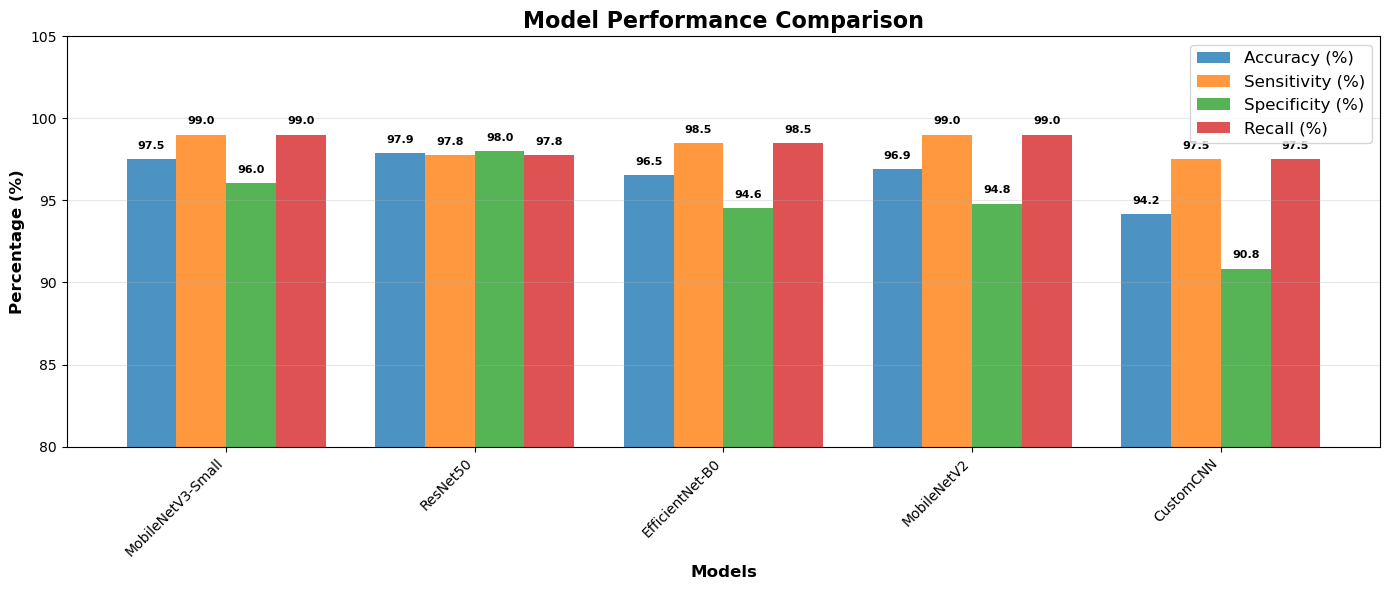

Performance comparison chart saved as: performance_comparison.png


<Figure size 640x480 with 0 Axes>

In [13]:
# Performance Comparison Graphs - Self-Collected Test Set Only
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for visualization
df_viz = pd.DataFrame(results)

# Create visualization
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

metrics = ['Accuracy (%)', 'Sensitivity (%)', 'Specificity (%)', 'Recall (%)']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red

# Prepare data for grouped bar chart
models = df_viz['Model'].values
accuracy = df_viz['Accuracy (%)'].values
sensitivity = df_viz['Sensitivity (%)'].values
specificity = df_viz['Specificity (%)'].values
recall = df_viz['Recall (%)'].values

# Set position of bars on x-axis
x = np.arange(len(models))
width = 0.2

# Create bars
ax.bar(x - 1.5*width, accuracy, width, label='Accuracy (%)', color=colors[0], alpha=0.8)
ax.bar(x - 0.5*width, sensitivity, width, label='Sensitivity (%)', color=colors[1], alpha=0.8)
ax.bar(x + 0.5*width, specificity, width, label='Specificity (%)', color=colors[2], alpha=0.8)
ax.bar(x + 1.5*width, recall, width, label='Recall (%)', color=colors[3], alpha=0.8)

# Customize the plot
ax.set_xlabel('Models', fontweight='bold', fontsize=12)
ax.set_ylabel('Percentage (%)', fontweight='bold', fontsize=12)
ax.set_title('Model Performance Comparison', fontweight='bold', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(fontsize=12)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(80, 105)  # Focus on the performance range

# Add value labels on bars
for j, (acc, sens, spec, rec) in enumerate(zip(accuracy, sensitivity, specificity, recall)):
    ax.text(j - 1.5*width, acc + 0.5, f'{acc:.1f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    ax.text(j - 0.5*width, sens + 0.5, f'{sens:.1f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    ax.text(j + 0.5*width, spec + 0.5, f'{spec:.1f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    ax.text(j + 1.5*width, rec + 0.5, f'{rec:.1f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

# Save the figure
plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
print("Performance comparison chart saved as: performance_comparison.png")